Vanilla Transformer Modeling

In [1]:
import math
import os
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import pandas as pd

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

In [2]:
CSV_PATH = "../../Data/eth_final_df.csv"

df = pd.read_csv(CSV_PATH)
if "timestamp" not in df.columns:
    raise ValueError("Expected a datetime column named 'timestamp' in the CSV.")
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")
df = df.sort_values("timestamp").dropna(subset=["timestamp"]).reset_index(drop=True)

TARGET_CANDIDATES = ["vol_future", "target", "y"]
target_col = None
for c in TARGET_CANDIDATES:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    raise ValueError(f"Could not find a target column among {TARGET_CANDIDATES}. "
                     "Please rename your target to one of these or edit the list.")

feature_cols = [c for c in df.columns if c not in ["timestamp", target_col]]
num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
X_raw = df[["timestamp"] + num_cols].copy()
y_raw = df[["timestamp", target_col]].copy()


In [3]:
def make_sequences(X_df: pd.DataFrame,
                   y_df: pd.DataFrame,
                   seq_len: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dfm = X_df.merge(y_df, on="timestamp", how="inner")
    dfm = dfm.sort_values("timestamp").reset_index(drop=True)

    values = dfm[num_cols].values.astype(np.float32)
    target = dfm[target_col].values.astype(np.float32)
    times  = dfm["timestamp"].values

    X_list, y_list, t_list = [], [], []
    for i in range(len(dfm) - seq_len + 1):
        X_list.append(values[i:i+seq_len])
        y_list.append(target[i+seq_len-1])   
        t_list.append(times[i+seq_len-1])

    return np.stack(X_list), np.array(y_list), np.array(t_list)


In [4]:
class SeqDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)  
        self.y = torch.from_numpy(y).float().view(-1, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model) 
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)*(-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  
    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, n_features: int, d_model: int, nhead: int,
                 num_layers: int, dim_feedforward: int, dropout: float):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation="relu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )
    def forward(self, x):
        x = self.input_proj(x)       
        x = self.pos_enc(x)             
        z = self.encoder(x)               
        z_last = z[:, -1, :]            
        return self.head(z_last)           


In [5]:
def make_purged_rolling_splits(timestamps: np.ndarray,
                               n_folds: int = 5,
                               purge_hours: int = 24) -> List[Tuple[np.ndarray, np.ndarray]]:
    ts = pd.to_datetime(pd.Series(timestamps)).sort_values().reset_index(drop=True)
    t_min, t_max = ts.iloc[0], ts.iloc[-1]
    cut_times = [t_min + i*(t_max - t_min)/n_folds for i in range(n_folds+1)]

    splits = []
    for f in range(n_folds):
        train_end = cut_times[f]          
        val_end   = cut_times[f+1]
        all_idx = pd.Series(range(len(ts)))
        train_mask = ts <= train_end
        purge_end = train_end + pd.Timedelta(hours=purge_hours)
        val_mask = (ts > purge_end) & (ts <= val_end)

        tr_idx = all_idx[train_mask].values
        va_idx = all_idx[val_mask].values

        if len(tr_idx) == 0 or len(va_idx) == 0:
            continue
        splits.append((tr_idx, va_idx))
    return splits

In [6]:
@dataclass
class TrainConfig:
    seq_len: int = 48
    batch_size: int = 64
    lr: float = 1e-3
    weight_decay: float = 1e-4
    max_epochs: int = 50
    patience: int = 7
    d_model: int = 64
    nhead: int = 4
    num_layers: int = 2
    dim_feedforward: int = 128
    dropout: float = 0.1

def rmse(y_true, y_pred): 
    return math.sqrt(mean_squared_error(y_true, y_pred))

def rmpse(y_true, y_pred, eps: float = 1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    pct = ((y_pred - y_true) / (np.abs(y_true) + eps))**2
    return float(np.sqrt(np.mean(pct)))

def qlike_variance(v_true, v_pred, eps: float = 1e-12) -> float:
    v_true = np.asarray(v_true, dtype=float)
    v_pred = np.asarray(v_pred, dtype=float)
    v_true = np.maximum(v_true, eps)
    v_pred = np.maximum(v_pred, eps)
    ratio = v_true / v_pred
    return float(np.mean(ratio - np.log(ratio) - 1.0))

def train_one(model, train_loader, val_loader, cfg: TrainConfig):
    model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    best_state = None
    best_val = float("inf")
    no_improve = 0

    for epoch in range(cfg.max_epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            pred = model(xb)
            loss = nn.MSELoss()(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                pred = model(xb)
                val_losses.append(nn.MSELoss()(pred, yb).item())
        val_mse = float(np.mean(val_losses))
        if val_mse < best_val - 1e-7:
            best_val = val_mse
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
        if no_improve >= cfg.patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val


In [7]:
def fold_score(cfg: TrainConfig,
               X_df: pd.DataFrame,
               y_df: pd.DataFrame,
               n_folds: int = 5,
               purge_hours: int = 24) -> Dict[str, float]:
    X_seq_raw, y_raw_vals, t_idx = make_sequences(X_df, y_df, seq_len=cfg.seq_len)

    splits = make_purged_rolling_splits(t_idx, n_folds=n_folds, purge_hours=purge_hours)
    if len(splits) == 0:
        raise ValueError("No valid folds constructed. Check your data coverage and seq_len.")

    rmse_list, rmpse_list, qlike_list = [], [], []
    for tr_idx, va_idx in splits:
        feat_scaler = RobustScaler()
        targ_scaler = StandardScaler()

        X_train = X_seq_raw[tr_idx]
        y_train = y_raw_vals[tr_idx]
        X_val   = X_seq_raw[va_idx]
        y_val   = y_raw_vals[va_idx]

        B, T, F = X_train.shape
        feat_scaler.fit(X_train.reshape(B*T, F))
        X_train_s = feat_scaler.transform(X_train.reshape(B*T, F)).reshape(B, T, F)
        X_val_s   = feat_scaler.transform(X_val.reshape(X_val.shape[0]*T, F)).reshape(X_val.shape[0], T, F)

        y_train_s = targ_scaler.fit_transform(y_train.reshape(-1,1)).ravel()
        y_val_s   = targ_scaler.transform(y_val.reshape(-1,1)).ravel()

        ds_tr = SeqDataset(X_train_s, y_train_s)
        ds_va = SeqDataset(X_val_s,   y_val_s)
        dl_tr = DataLoader(ds_tr, batch_size=cfg.batch_size, shuffle=True,  drop_last=False)
        dl_va = DataLoader(ds_va, batch_size=cfg.batch_size, shuffle=False, drop_last=False)

        model = TimeSeriesTransformer(
            n_features=X_train.shape[-1],
            d_model=cfg.d_model,
            nhead=cfg.nhead,
            num_layers=cfg.num_layers,
            dim_feedforward=cfg.dim_feedforward,
            dropout=cfg.dropout
        )

        model, _ = train_one(model, dl_tr, dl_va, cfg)

        model.eval()
        yhat_s = []
        with torch.no_grad():
            for xb, _ in dl_va:
                yhat_s.append(model(xb.to(DEVICE)).cpu().numpy().ravel())
        yhat_s = np.concatenate(yhat_s)
        yhat = targ_scaler.inverse_transform(yhat_s.reshape(-1,1)).ravel()
        y_gt = y_val
        v_true = np.square(y_gt)
        v_pred = np.square(yhat)

        rmse_list.append(rmse(v_true, v_pred))
        rmpse_list.append(rmpse(v_true, v_pred))
        qlike_list.append(qlike_variance(v_true, v_pred))

    return {
        "RMSE":  float(np.mean(rmse_list)),
        "RMPSE": float(np.mean(rmpse_list)),
        "QLIKE": float(np.mean(qlike_list)),
    }

In [8]:
from itertools import product

SEARCH_SPACE = {
    "seq_len":         [1, 2, 6, 12, 24, 36, 48, 72],
    "batch_size":      [8, 32, 64, 128],
    "lr":              [1e-3, 3e-4, 1e-4],
    "weight_decay":    [1e-5, 1e-4, 3e-4],
    "d_model":         [64, 96, 128],
    "nhead":           [2, 4, 8],
    "num_layers":      [1, 2, 3],
    "dim_feedforward": [128, 256, 384],
    "dropout":         [0.1, 0.2, 0.3],
    "max_epochs":      [40, 60],
    "patience":        [6, 8],
}

def sample_cfg() -> TrainConfig:
    def s(k): return random.choice(SEARCH_SPACE[k])
    return TrainConfig(
        seq_len=s("seq_len"),
        batch_size=s("batch_size"),
        lr=s("lr"),
        weight_decay=s("weight_decay"),
        d_model=s("d_model"),
        nhead=s("nhead"),
        num_layers=s("num_layers"),
        dim_feedforward=s("dim_feedforward"),
        dropout=s("dropout"),
        max_epochs=s("max_epochs"),
        patience=s("patience"),
    )

N_TRIALS = 20
results = []
for t in range(N_TRIALS):
    cfg = sample_cfg()
    n_total = len(X_raw)
    split_idx = int(n_total * 0.85)
    X_train= X_raw[:split_idx]
    y_train= y_raw[:split_idx]
    scores = fold_score(cfg, X_raw, y_raw, n_folds=5, purge_hours=24)
    row = {"trial": t, **scores, **cfg.__dict__}
    results.append(row)
    print(f"[{t+1}/{N_TRIALS}] RMSE={scores['RMSE']:.6f}  RMPSE={scores['RMPSE']:.6f}  QLIKE={scores['QLIKE']:.8f}  cfg={cfg}")

res_df = pd.DataFrame(results)

res_df = res_df.sort_values("RMSE", ascending=True).reset_index(drop=True)
res_df.head(10)


[1/20] RMSE=0.018851  RMPSE=720.127804  QLIKE=1.67381350  cfg=TrainConfig(seq_len=2, batch_size=8, lr=0.0001, weight_decay=0.0001, max_epochs=40, patience=8, d_model=64, nhead=2, num_layers=1, dim_feedforward=384, dropout=0.1)
[2/20] RMSE=0.367013  RMPSE=33146.591771  QLIKE=2.48704259  cfg=TrainConfig(seq_len=1, batch_size=8, lr=0.001, weight_decay=1e-05, max_epochs=40, patience=8, d_model=64, nhead=8, num_layers=3, dim_feedforward=128, dropout=0.3)
[3/20] RMSE=0.031472  RMPSE=2921.333300  QLIKE=17.62091154  cfg=TrainConfig(seq_len=12, batch_size=128, lr=0.0001, weight_decay=0.0001, max_epochs=60, patience=6, d_model=64, nhead=2, num_layers=3, dim_feedforward=256, dropout=0.2)
[4/20] RMSE=0.048109  RMPSE=2729.532424  QLIKE=2.05452668  cfg=TrainConfig(seq_len=12, batch_size=64, lr=0.001, weight_decay=1e-05, max_epochs=60, patience=6, d_model=96, nhead=2, num_layers=2, dim_feedforward=256, dropout=0.3)


KeyboardInterrupt: 

In [ ]:
best_cfg_dict = res_df.iloc[0].to_dict()
best_cfg = TrainConfig(
    seq_len=int(best_cfg_dict["seq_len"]),
    batch_size=int(best_cfg_dict["batch_size"]),
    lr=float(best_cfg_dict["lr"]),
    weight_decay=float(best_cfg_dict["weight_decay"]),
    d_model=int(best_cfg_dict["d_model"]),
    nhead=int(best_cfg_dict["nhead"]),
    num_layers=int(best_cfg_dict["num_layers"]),
    dim_feedforward=int(best_cfg_dict["dim_feedforward"]),
    dropout=float(best_cfg_dict["dropout"]),
    max_epochs=int(best_cfg_dict["max_epochs"]),
    patience=int(best_cfg_dict["patience"]),
)


In [ ]:
X_seq, y_seq, t_seq = make_sequences(X_raw, y_raw, seq_len=best_cfg.seq_len)
n_total = len(X_seq)
split_idx = int(n_total * 0.85)

X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
t_train, t_test = t_seq[:split_idx], t_seq[split_idx:]


In [ ]:
feat_scaler = RobustScaler()
targ_scaler = StandardScaler()

B, T, F = X_train.shape
feat_scaler.fit(X_train.reshape(B*T, F))
X_train_s = feat_scaler.transform(X_train.reshape(B*T, F)).reshape(B, T, F)
X_test_s  = feat_scaler.transform(X_test.reshape(X_test.shape[0]*T, F)).reshape(X_test.shape[0], T, F)

y_train_s = targ_scaler.fit_transform(y_train.reshape(-1,1)).ravel()
y_test_s  = targ_scaler.transform(y_test.reshape(-1,1)).ravel()

ds_tr = SeqDataset(X_train_s, y_train_s)
ds_te = SeqDataset(X_test_s,  y_test_s)
dl_tr = DataLoader(ds_tr, batch_size=best_cfg.batch_size, shuffle=True)
dl_te = DataLoader(ds_te, batch_size=best_cfg.batch_size, shuffle=False)

model = TimeSeriesTransformer(
    n_features=X_train.shape[-1],
    d_model=best_cfg.d_model,
    nhead=best_cfg.nhead,
    num_layers=best_cfg.num_layers,
    dim_feedforward=best_cfg.dim_feedforward,
    dropout=best_cfg.dropout
)
model, _ = train_one(model, dl_tr, dl_te, best_cfg)


In [ ]:
model.eval()
yhat_s = []
with torch.no_grad():
    for xb, _ in dl_te:
        xb = xb.to(DEVICE)
        yhat_s.append(model(xb).cpu().numpy().ravel())
yhat_s = np.concatenate(yhat_s)

yhat = targ_scaler.inverse_transform(yhat_s.reshape(-1,1)).ravel()
y_true = y_test
t_test = pd.to_datetime(t_test)


Plotting the result

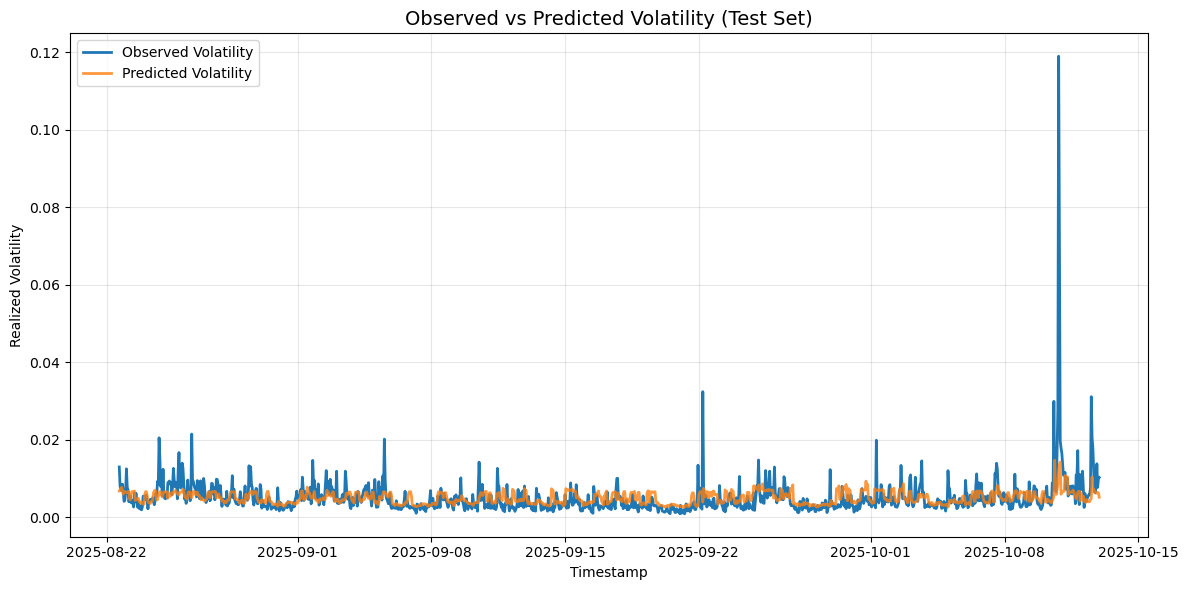

Test RMSE = 0.004561
Test RMPSE = 0.734273
Test QLIKE = 0.71230172


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(t_test, y_true, label="Observed Volatility", linewidth=2)
plt.plot(t_test, yhat, label="Predicted Volatility", linewidth=2, alpha=0.8)
plt.title("Observed vs Predicted Volatility (Test Set)", fontsize=14)
plt.xlabel("Timestamp")
plt.ylabel("Realized Volatility")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Test RMSE = {rmse(np.square(y_true), np.square(y_true)):.6f}")
print(f"Test RMPSE = {rmpse(np.square(y_true), np.square(y_true)):.6f}")
print(f"Test QLIKE = {qlike_variance(np.square(y_true), np.square(yhat)):.8f}")


Feature Importance

In [ ]:
pip install captum


  Using cached captum-0.8.0-py3-none-any.whl.metadata (26 kB)
Using cached captum-0.8.0-py3-none-any.whl (1.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from captum.attr import IntegratedGradients, DeepLift, Saliency
import torch

xb_sample = torch.tensor(X_test_s[-10:], dtype=torch.float32).to(DEVICE)  
yb_sample = torch.tensor(y_test_s[-10:], dtype=torch.float32).to(DEVICE)


In [ ]:
def forward_fn(x):
    return model(x).squeeze(1)


In [ ]:
ig = IntegratedGradients(forward_fn)
attributions, delta = ig.attribute(
    xb_sample,
    target=None,          
    n_steps=50,
    return_convergence_delta=True
)


In [ ]:
attr_mean = attributions.mean(dim=(0,1)).detach().cpu().numpy()

feat_importance = pd.DataFrame({
    "feature": num_cols,
    "importance": attr_mean
}).sort_values("importance", key=np.abs, ascending=False)

print(feat_importance.head(10))


                     feature  importance
10                      high   -0.103202
2                 RV_MA_12hr    0.097121
12             hourly_return    0.084424
8                       open   -0.078995
6          transaction_count    0.054700
15  avg_priority_fee_usd_log    0.042732
0                  RV_MA_1hr    0.034744
3   active_sending_addresses   -0.023458
13    onchain_volume_usd_log    0.016169
1                  RV_MA_3hr    0.014608


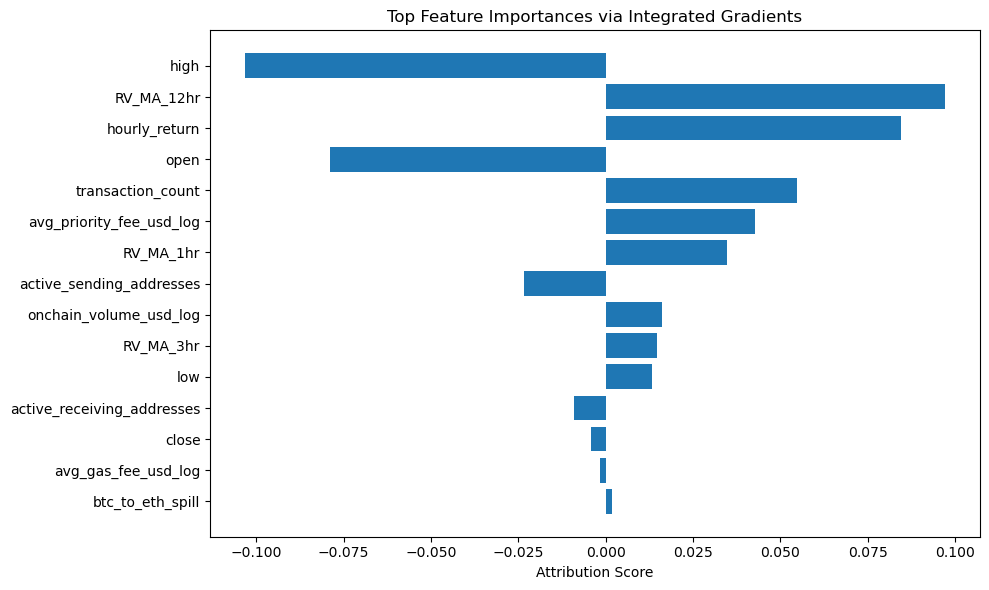

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(feat_importance["feature"][:15], feat_importance["importance"][:15])
plt.gca().invert_yaxis()
plt.title("Top Feature Importances via Integrated Gradients")
plt.xlabel("Attribution Score")
plt.tight_layout()
plt.show()


Saving predicted result for backtesting

In [ ]:
pred_df = pd.DataFrame({
    "timestamp": pd.to_datetime(t_test),
    "observed_volatility": y_true,
    "predicted_volatility": yhat
})

In [ ]:
save_path = "../../Results/eth_transformer_prediction.csv"
pred_df.to_csv(save_path, index=False)
print(f"✅ Saved test predictions to {save_path}")
print(pred_df.head())


✅ Saved test predictions to eth_transformer_prediction.csv
            timestamp  observed_volatility  predicted_volatility
0 2025-08-22 16:00:00             0.012928              0.006735
1 2025-08-22 17:00:00             0.007970              0.006735
2 2025-08-22 18:00:00             0.007213              0.007439
3 2025-08-22 19:00:00             0.006859              0.007620
4 2025-08-22 20:00:00             0.008493              0.006868
